<a href="https://colab.research.google.com/github/tesyaeriana/Machine_Learning/blob/main/pertemuan_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NAMA: TESYA ERIANA**<br>
**No ABSEN: 28**<br>
**KELAS: TI-3A**<br>
**PERTEMUAN 10: RECURRENT NEURAL NETWORK**


**PRAKTIKUM 1: RNN UNTUK ANALISIS SENTIMEN**


> **Setup**



In [ ]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])



> **Setup input pipeline**<br>Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.Download dataset menggunakan TFDS.




In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset.element_spec


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))



> Mengembalikan dataset(teks, pasangan label)



In [ ]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0




> Mengacak data untuk pelatihan dan membuat kumpulan pasangan (teks, label)



In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])


texts:  [b'i didn\'t even bother finishing the movie because i was so bored i thought i was going to pass out i was watching it in the movie theaters and me and my friends just got tired so we got up and left to another movie if i ever have to sit through 2 min. of that movie again i think I\'m going to shoot myself...and i do know the whole entire movie because my friend told me what happened at the end and i wasn\'t surprised at all i mean who didn\'t know she was going to do the right thing and let him be happy i mean for real you would have to be a complete idiot not to know that. i know i didn\'t miss anything and if somebody ask\'s me to see that movie i would say "over my dead body".'
 b'I hate this programme: not only is the very concept ludicrous, but it tries so hard to be feasible (something that was left out of similar "I confess" ending programmes like, Muder: She Wrote).<br /><br />Sigh. Why is it that the writers can\'t ever be intelligent enough in this programme to com



> **Buat Teks Encoder**



In [ ]:
#membuat lapisan dan teruskan teks kumpulan data ke metode adapt lapisan.
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))


In [ ]:
# melihat 20 token pertama
vocab = np.array(encoder.get_vocabulary())
vocab[:20]


array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10, 153,  54, ...,   0,   0,   0],
       [ 10, 782,  11, ...,   0,   0,   0],
       [ 10,   1,  58, ...,   0,   0,   0]])

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'i didn\'t even bother finishing the movie because i was so bored i thought i was going to pass out i was watching it in the movie theaters and me and my friends just got tired so we got up and left to another movie if i ever have to sit through 2 min. of that movie again i think I\'m going to shoot myself...and i do know the whole entire movie because my friend told me what happened at the end and i wasn\'t surprised at all i mean who didn\'t know she was going to do the right thing and let him be happy i mean for real you would have to be a complete idiot not to know that. i know i didn\'t miss anything and if somebody ask\'s me to see that movie i would say "over my dead body".'
Round-trip:  i didnt even [UNK] [UNK] the movie because i was so [UNK] i thought i was going to [UNK] out i was watching it in the movie [UNK] and me and my friends just got [UNK] so we got up and left to another movie if i ever have to sit through 2 [UNK] of that movie again i think im going to 



> **Membuat Model**



In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 2s 2s/step
[0.00863889]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 61ms/step
[0.00863889]


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])



> **Train Model**





In [ ]:
history = model.fit(train_dataset, epochs=10,validation_data=test_dataset,validation_steps=30)

Epoch 1/10
391/391 [==============================] - 46s 93ms/step - loss: 0.6566 - accuracy: 0.5495 - val_loss: 0.5017 - val_accuracy: 0.7255
Epoch 2/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3958 - accuracy: 0.8188 - val_loss: 0.3689 - val_accuracy: 0.8172
Epoch 3/10
391/391 [==============================] - 27s 69ms/step - loss: 0.3346 - accuracy: 0.8525 - val_loss: 0.3507 - val_accuracy: 0.8260
Epoch 4/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3161 - accuracy: 0.8623 - val_loss: 0.3301 - val_accuracy: 0.8516
Epoch 5/10
391/391 [==============================] - 27s 69ms/step - loss: 0.3091 - accuracy: 0.8657 - val_loss: 0.3350 - val_accuracy: 0.8328
Epoch 6/10
391/391 [==============================] - 27s 70ms/step - loss: 0.3050 - accuracy: 0.8674 - val_loss: 0.3197 - val_accuracy: 0.8568
Epoch 7/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3047 - accuracy: 0.8669 - val_loss: 0.3212 - val_accuracy:

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 12s 32ms/step - loss: 0.3155 - accuracy: 0.8531
Test Loss: 0.31552186608314514
Test Accuracy: 0.8531200289726257


(0.0, 0.6746888846158982)

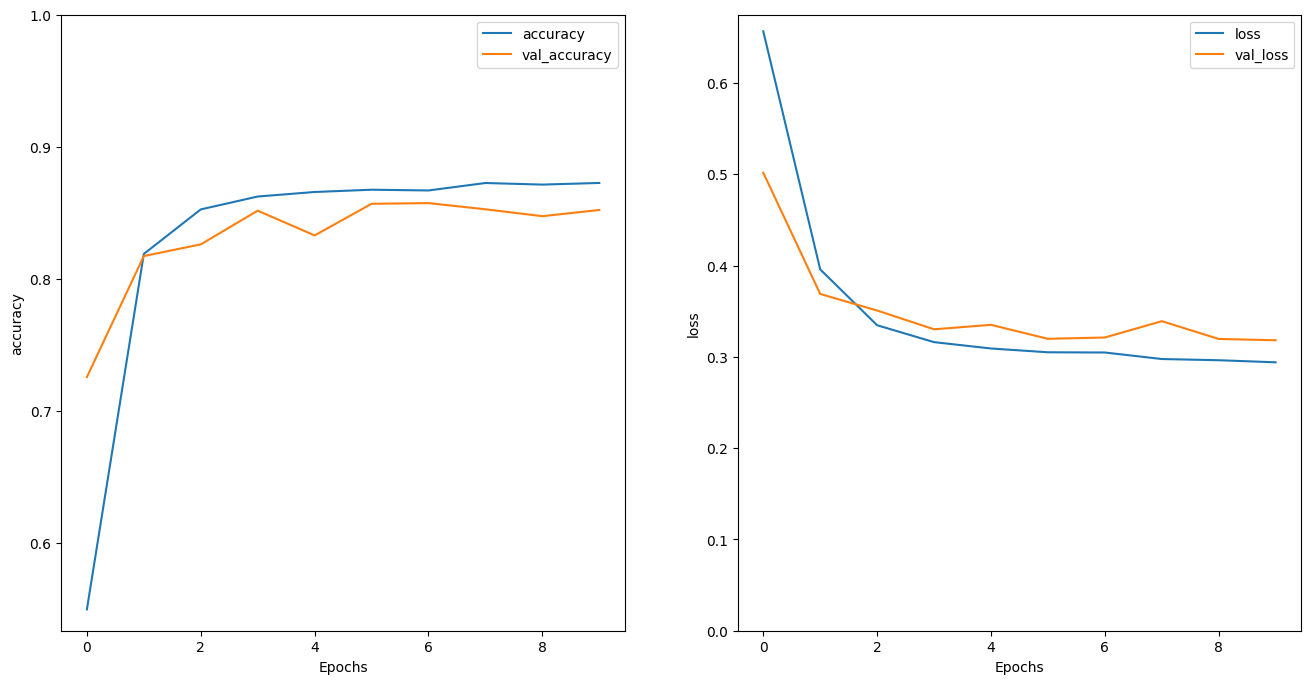

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
sample_text = ('The Movie was cool. The animation and the graphics' 'were out of thid world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 2s 2s/step
[[1.0481746]]




> **Stack two or more LSTM layers**



In [ ]:
model = tf.keras.Sequential([encoder,tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), tf.keras.layers.Dense(64, activation='relu'),tf.keras.layers.Dropout(0.5),tf.keras.layers.Dense(1)])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(1e-4), metrics=['accuracy'])

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 30s 55ms/step - loss: 0.6931 - accuracy: 0.5000
Test Loss: 0.6931041479110718
Test Accuracy: 0.5


In [ ]:
# predict on a sample text without padding.
sample_text = ('The movie was not good. The animation and the graphics' 'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[0.00094352]]


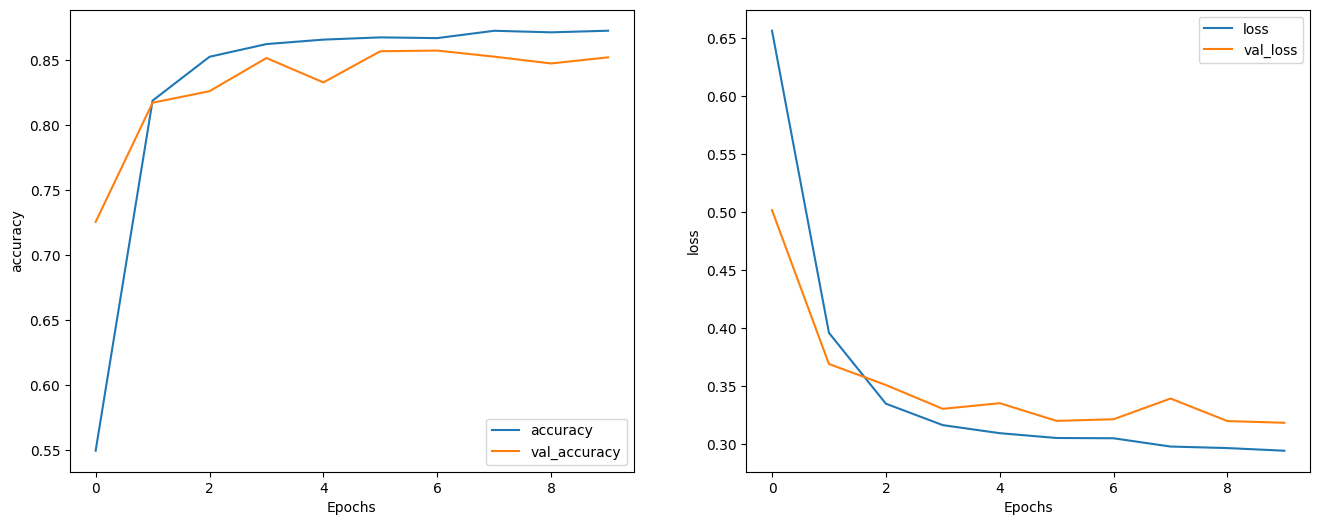

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

**PRAKTIKUM 2:GENERATOR TEKS DENGAN RNN**

In [ ]:
import tensorflow as tf
import numpy as np
import os
import time

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt','https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')


In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters




> **OLAH TEKS**



In [ ]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(vocabulary = list(vocab), mask_token=None)

In [ ]:
ids = ids_from_chars(chars)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(vocabulary = ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)



> **Prediksi**



In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
  print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length=100

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [ ]:
for seq in sequences.take(5):
  print(chars_from_ids(seq).numpy())

[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' ']
[b'a' b'r' b'e' b' ' b'a' b'l' b'l' b' ' b'r' b'e' b's' b'o' b'l' b'v'
 b'e' b'd' b' ' b'r' b'a' b't' b'h' b'e' b'r' b' ' b't' b'o' b' ' b'd'
 b'i' b'e' b' ' b't' b'h' b'a' b'n' b' ' b't' b'o' b' ' b'f' b'a' b'm'
 b'i' b's' b'h' b'?' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'R' b'e' b's'
 b'o' b'l' b'v' b'e' b'd' b'.' b' ' b'r' b'e' b's' b'o' b'l' b'v' b'e'
 b'd' b'.' b'\n' b'\n' b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i'
 b'z' b'e' b'n' b':' b'\n' b'F' b'i' b'r' b's' b

In [ ]:
def split_input_target(sequence):
  input_text = sequence[:-1]
  target_text = sequence[1:]
  return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))


(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
  print("Input :", text_from_ids(input_example).numpy())
  print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '




> **Membuat Batch Training**



In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>



> **Membuat Model**



In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(vocab_size=vocab_size,embedding_dim=embedding_dim,rnn_units=rnn_units)



> **Menguji Model**



In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [ ]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_8 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
sampled_indices

array([57,  6, 62, 36, 57, 42, 65,  6, 14, 32, 42, 30, 55, 30,  0, 36, 30,
       25, 59, 12, 24, 62, 43, 22, 31, 43, 40, 14, 57, 21, 42, 46, 62, 42,
        1, 51, 40, 41, 57, 64, 14, 14,  2, 35, 12, 36, 16, 23, 40, 61, 14,
       38, 43, 33, 19, 57, 45, 28, 28,  6, 63, 52, 24, 59,  3, 13,  0, 17,
       50, 64, 15, 49, 46, 14, 25, 23, 50, 24,  4, 33, 20, 45, 42, 43,  5,
       17, 28, 14, 26, 36, 56, 41, 50, 58, 38, 46, 53, 36,  2, 10])

In [ ]:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b'ur action.\n\nMARCIUS:\nThose are they\nThat most are willing. If any such be here--\nAs it were sin to d'

Next Char Predictions:
 b"r'wWrcz'AScQpQ[UNK]WQLt;KwdIRdaArHcgwc\nlabryAA V;WCJavAYdTFrfOO'xmKt!?[UNK]DkyBjgALJkK$TGfcd&DOAMWqbksYgnW 3"




> **Train Model**



In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.190469, shape=(), dtype=float32)


In [ ]:
tf.exp(example_batch_mean_loss).numpy()

66.05375

In [ ]:
model.compile(optimizer='adam',loss=loss)

In [ ]:
#Konfigurasi Checkpoints
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,save_weights_only=True)

In [ ]:
#Melakukan Proses training
EPOCHS = 10
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
172/172 [==============================] - 15s 58ms/step - loss: 2.7159
Epoch 2/10
172/172 [==============================] - 13s 59ms/step - loss: 1.9901
Epoch 3/10
172/172 [==============================] - 11s 56ms/step - loss: 1.7171
Epoch 4/10
172/172 [==============================] - 11s 56ms/step - loss: 1.5563
Epoch 5/10
172/172 [==============================] - 12s 56ms/step - loss: 1.4571
Epoch 6/10
172/172 [==============================] - 11s 56ms/step - loss: 1.3894
Epoch 7/10
172/172 [==============================] - 11s 55ms/step - loss: 1.3360
Epoch 8/10
172/172 [==============================] - 12s 57ms/step - loss: 1.2913
Epoch 9/10
172/172 [==============================] - 11s 57ms/step - loss: 1.2503
Epoch 10/10
172/172 [==============================] - 12s 56ms/step - loss: 1.2106




> **Membuat Prediksi Satu Langkah**



In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [ ]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:
Wrath mine hand that sets thy prison.

DUKE VINCENTIO:
O thus firmly shalt to, Sant thou that paisonous Lord Clarence; Thou dirst be
warrant, by the more that made the boing for
traitor to what you have sale tog,
Which, we'll allow our father: but,
Which lateful quarrel sons, friznds the way
To sit my thought.
The totors, may ye come, though straight
The warrant, fair Lely spent.

ROMEO:
Can you spend my lady slipt and grace.
Nor Englord, all embraceing; But thou canst young Richmond,
The lecturess of shoets boy; therefore stip kisses;
By night nor news. Is it we shall risten and close.
Who executed I have relaced
me.

MENENIUS:
Ye' pardon it!

HENRY BOLINGBROKE:
Faith, let me do not? but it now till she be betray.
Bay me, sir. Green King 'Thanks.

DUKE VINCENTIO:
And see you had you speak three, disback of my husband, the goldew--key of our:
The child, well hably our light-indinney of my fill.

with more rest,
Scandally, and good expedience?
I am but old enoughs for the good lo

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nShe with your stell,--good to malican on my hearth,\nThe bubied of thee, or that here I know aid\nBrother: for I hear made pray my mind power:\n'First, Warwick, and many glassless gangerous.\n\nROMEO:\nIt not let me sep' all:\nThough for Grumilise should help terrs of his finisher\nThat mathers, in the steed all best from me.\nWhat a share-bear her, back to eatten me:\nNow now; therefore, thereby the litterst childness twice\nSome sharp writ, in the uttion for so smoiled foot\nIf good old gallayation as you show for me\nwhat the present in the lights, who common it ere lies\nAnd once they feel;\nFor tell me, their words opening, whereof the land there?\n\nDOKES:\nNay, but, as good friends: if Nayures:\nHow love his father and a stark\nand tongue the like noble Brother Hathard hath\nA mater What all the people\nOf the midation of his marquies,\nThat liberty straight through the feal'st gramits living\nUstoe where still down through: set\nthat ask'd up: whither be g



> **Ekspor Model Generator**




In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Come; your gracious soul:' but little lie, imprison'd person:
Unless of blood, that vistague, Henry


**TUGAS**

Prosedur pelatihan pada praktikum 2 merupakan prosedur sederhana, yang tidak memberi Anda banyak kendali. Model ini menggunakan "teacher-forcing" yang mencegah prediksi buruk diumpankan kembali ke model, sehingga model tidak pernah belajar untuk pulih dari kesalahan. Jadi, setelah Anda melihat cara menjalankan model secara manual, selanjutnya Anda akan mengimplementasikan custom loop pelatihan. Hal ini memberikan titik awal jika, misalnya, Anda ingin menerapkan pembelajaran kurikulum untuk membantu menstabilkan keluaran open-loop model. Bagian terpenting dari loop pelatihan khusus adalah fungsi langkah pelatihan. Gunakan tf.GradientTape untuk men track nilai gradient. Anda dapat mempelajari lebih lanjut tentang pendekatan ini dengan membaca eager execution guide.

Prosedurnya adalah :

1. Jalankan Model dan hitung loss dengan tf.GradientTape.
2. Hitung update dan terapkan pada model dengan optimizer

In [ ]:
class CustomTraining(MyModel):
 @tf.function
 def train_step(self, inputs):
      inputs, labels = inputs
      with tf.GradientTape() as tape:
        predictions = self(inputs, training=True)
        loss = self.loss(labels, predictions)
      grads = tape.gradient(loss, model.trainable_variables)
      self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

      return {'loss': loss}

Kode diatas menerapkan train_step method sesuai dengan  Keras' train_step conventions. Ini opsional, tetapi memungkinkan Anda mengubah perilaku langkah pelatihan dan tetap menggunakan keras Model.compile and Model.fit methods.

In [ ]:
model = CustomTraining(
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
model.fit(dataset, epochs=1)

172/172 [==============================] - 15s 59ms/step - loss: 1.1823


Atau jika ingin lebih mengetahui dalamnya, kita bisa membuat custom training loop sendiri:

In [ ]:
EPOCHS = 10

mean = tf.metrics.Mean()

for epoch in range(EPOCHS):
    start = time.time()

    mean.reset_states()
    for (batch_n, (inp, target)) in enumerate(dataset):
      logs = model.train_step([inp, target])
      mean.update_state(logs['loss'])

      if batch_n % 50 == 0:
         template = f"Epoch {epoch+1} Batch {batch_n} Loss {logs['loss']:.4f}"
         print(template)

 # saving (checkpoint) the model every 5 epochs
      if (epoch + 1) % 5 == 0:
         model.save_weights(checkpoint_prefix.format(epoch=epoch))

    print()
    print(f'Epoch {epoch+1} Loss: {mean.result().numpy():.4f}')
    print(f'Time taken for 1 epoch {time.time() - start:.2f} sec')
    print("_"*80)

model.save_weights(checkpoint_prefix.format(epoch=epoch))

Epoch 1 Batch 0 Loss 1.1818
Epoch 1 Batch 50 Loss 1.1666
Epoch 1 Batch 100 Loss 1.1606
Epoch 1 Batch 150 Loss 1.1578

Epoch 1 Loss: 1.1642
Time taken for 1 epoch 20.47 sec
________________________________________________________________________________
Epoch 2 Batch 0 Loss 1.1567
Epoch 2 Batch 50 Loss 1.1448
Epoch 2 Batch 100 Loss 1.1383
Epoch 2 Batch 150 Loss 1.1344

Epoch 2 Loss: 1.1414
Time taken for 1 epoch 12.85 sec
________________________________________________________________________________
Epoch 3 Batch 0 Loss 1.1332
Epoch 3 Batch 50 Loss 1.1229
Epoch 3 Batch 100 Loss 1.1160
Epoch 3 Batch 150 Loss 1.1113

Epoch 3 Loss: 1.1190
Time taken for 1 epoch 13.21 sec
________________________________________________________________________________
Epoch 4 Batch 0 Loss 1.1095
Epoch 4 Batch 50 Loss 1.0995
Epoch 4 Batch 100 Loss 1.0923
Epoch 4 Batch 150 Loss 1.0869

Epoch 4 Loss: 1.0952
Time taken for 1 epoch 12.51 sec
_____________________________________________________________________